In [4]:
import numpy as np
import mplhep as hep
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score
import uproot as up
import pandas as pd 
import awkward as ak
import os

from training_offline import Trainer, plot_ROC

In [ ]:
Y_forest = Trainer("Y")
Y_forest.complete_load()
Y_forest.plot_model()

In [ ]:
Y_tree = Trainer("Y")
Y_tree.complete_load()
Y_tree.plot_model()

In [ ]:
plot_ROC(Y_tree.dtrain,Y_tree.dval,[Y_tree.bst,Y_forest.bst], ["GB tree", "Boosted RF"])

Now look for optimal discriminators

In [3]:
predY = Y_tree.bst.predict(xgb.DMatrix(Y_tree.trainData_skinny))

In [4]:
#Study cuts on discriminators to optimize for Y

id1Y=Y_tree.trainData["Muon_softMva1"]
id2Y=Y_tree.trainData["Muon_softMva2"]
sig_cut = Y_tree.trainData["Score"]==1
bkg_cut = Y_tree.trainData["Score"]==0

def efficiencyY(id_lim,dis_lim):
    sig = (predY[sig_cut] > dis_lim) & (id1Y[sig_cut] > id_lim) & (id2Y[sig_cut] > id_lim)
    s = np.sum(sig)
    bkg = (predY[bkg_cut] > dis_lim) & (id1Y[bkg_cut] > id_lim) & (id2Y[bkg_cut] > id_lim)
    b = np.sum(bkg)
    return s/np.sqrt(b) if b!= 0 else 0


In [ ]:
id_vals = np.linspace(0.2,0.5,50)
vtx_vals= np.linspace(0.45,0.9,50)
XY, YY = np.meshgrid(id_vals,vtx_vals)
effY = np.vectorize(efficiencyY)(XY,YY)
idxY = np.unravel_index(np.argmax(effY),effY.shape)
print("Optimal discriminator cuts: \n SoftMVA (Muon ID): ", XY[idxY], "\n BDT (Vertex quantities): ", YY[idxY])

Optimal discriminator cuts: 
 SoftMVA (Muon ID):  0.39591836734693875 
 BDT (Vertex quantities):  0.7969387755102041


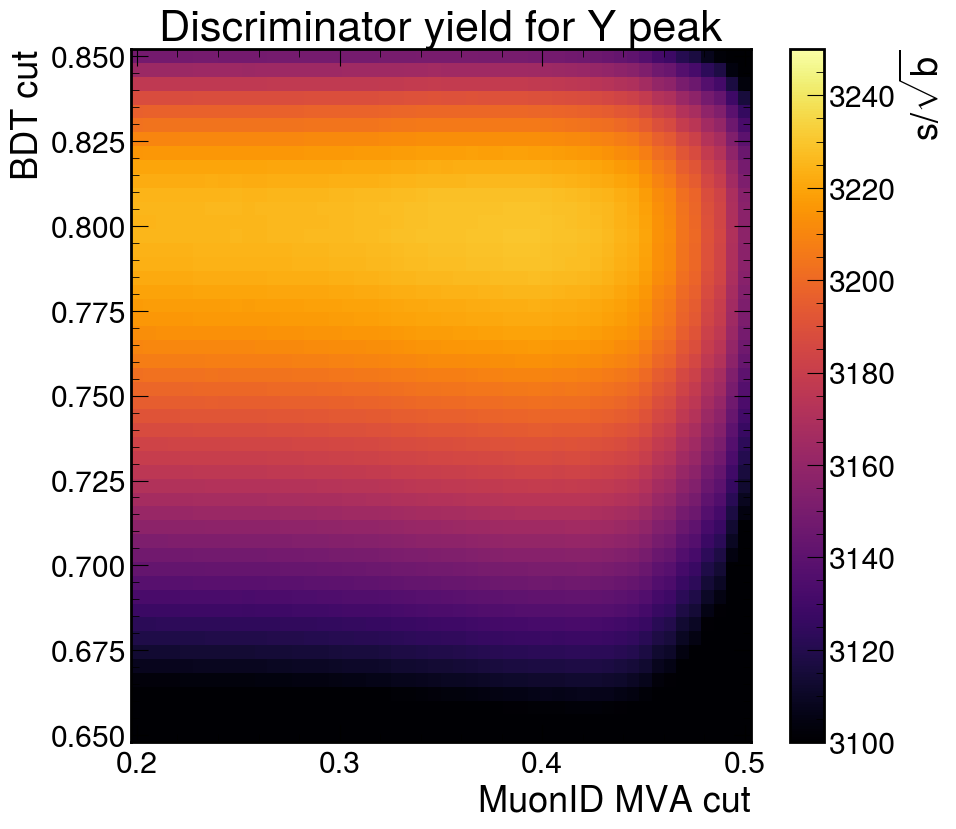

In [ ]:
plt.figure(figsize=(10, 9))
pcm = plt.pcolormesh(XY, YY, effY, shading='auto', cmap='inferno')# norm=matplotlib.colors.LogNorm()
colorbar = plt.colorbar(pcm, label='$s/\sqrt{b}$')
# colorbar_ticks = [1000,1300 , 2000]  # Define your desired tick positions
# colorbar.set_ticks(colorbar_ticks)
plt.xlabel('MuonID MVA cut')
plt.ylabel('BDT cut')
plt.title('Discriminator yield for Y peak')
# plt.ylim(0.65,0.85)
plt.show()